In [1]:
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import pandas as pd

In [2]:
import math

import seaborn as sns

# charge prediction
 - find threshold

In [3]:
def reshapeOneHot(X):
    X = np.dstack(X)
    X = np.swapaxes(X, 1, 2)
    X = np.swapaxes(X, 0, 1)
    return X

def one_hot_encode_peptide(peptide, MAX_LENGTH = 41):
    if len(peptide) > MAX_LENGTH:
        print('Peptide length is larger than maximal length of ', str(MAX_LENGTH))
        return None
    else:
        AA_vocabulary = 'KRPTNAQVSGILCMJHFYWEDBXO'#B: acetyl; O: Carbamyl; J: oxidized Met; X:pyro_glu
        no_not_used_aas = 1#U: not used

        one_hot_peptide = np.zeros((len(peptide), len(AA_vocabulary) - no_not_used_aas))

        for j in range(0, len(peptide)):
            try:
                aa = peptide[j]
                one_hot_peptide[j, AA_vocabulary.index(aa)] = 1
            except:
                pass
        
        no_front_paddings = int((MAX_LENGTH - len(peptide))/2)
        peptide_front_paddings = np.zeros((no_front_paddings, one_hot_peptide.shape[1]))

        no_back_paddings = MAX_LENGTH - len(peptide) - no_front_paddings
        peptide_back_paddings = np.zeros((no_back_paddings, one_hot_peptide.shape[1]))

        full_one_hot_peptide = np.vstack((peptide_front_paddings, one_hot_peptide, peptide_back_paddings))

        return peptide, full_one_hot_peptide
    
AA_vocabulary = 'KRPTNAQVSGILCMJHFYWEDBXOU'#B: acetyl; J: oxidized Met; X:pyro_glu
single2psi_lookup = {'B': '(Acetyl)-',
                     'J': 'M(Oxidation)',
                     'X': '(Gln->pyro-Glu)Q',
                     'C': 'C(Carbamidomethyl)'}

def one_hot_to_single_ptm(one_hot):
    seq = ''
    for row in one_hot:
        if row.sum() > 0:
            idx = row.argmax()
            seq += AA_vocabulary[idx]
    return seq



def single_ptm_to_psi(single_ptm_seq):
    psi_seq = single_ptm_seq
    for code in single2psi_lookup:
        psi_seq = psi_seq.replace(code, single2psi_lookup[code])
    return psi_seq

fn1 = '../refModel/2019MCP_Guan/LCMSMS_Pred_Supplemental_Material_section_S6/ChargeState/zfit_bidirLSTM2_masking_result.pickle'
with open(fn1, 'rb') as fid:
    pred_data = pickle.load(fid)

fn2 = '../refModel/2019MCP_Guan/LCMSMS_Pred_Supplemental_Material_section_S6/ChargeState/zfit_one_hot.pickle'
with open(fn2, 'rb') as fid:
    real_data = pickle.load(fid)

def plot_zfit(train_X, train_y, predicted_train_y, n):

    X = train_X[n]
    s_seq = one_hot_to_single_ptm(X)
    print(s_seq)
    psi_seq = single_ptm_to_psi(s_seq)
    print(psi_seq)
   
    y_exp = train_y[n]
    y_pred = predicted_train_y[n]
    pcc = pearsonr(y_exp, y_pred)

    fig, ax = plt.subplots()
    charges = range(1, len(y_exp) + 1)
    ax.stem(charges, y_exp, 'b', markerfmt=" ", label='Experimental')
    ax.stem(charges, -y_pred, 'g', markerfmt=" ", label='Predicted')
    plt.text(1.5, -0.35, 'pcc: %6.3f, %6.3g'%(pcc[0], pcc[1]))
    plt.xticks(charges)
    plt.xlabel('charge')
    plt.title(psi_seq)
    plt.show()

In [3]:
network_ori = tf.keras.models.load_model('../refModel/2019MCP_Guan/LCMSMS_Pred_Supplemental_Material_section_S6/ChargeState/zfit_bidirLSTM2_masking_model.h5')

print(network_ori.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 23)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         573440    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 2,280,965
Trainable params: 2,280,965
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [7]:
df.shape, len(df.PEP.unique()), len(ided_pep)

((510472, 8), 492693, 242846)

In [6]:
ided_pep = df.loc[df.ID==1].PEP.unique()
whole_pep = df.PEP.unique()

# Search Threshold
 - 몇 이상의 값을 가진 charge를 사용할 것인가, 나머지는 zero padding 해야한다.

In [8]:
df_kb = pd.read_csv('../data/massIVE-KB/df_kb_noptm.csv')
df_uni = pd.read_csv('../data/uniprot/df_uni_noptm_ided.csv')

df_kb_not6charge = df_kb.loc[df_kb.CHARGE!=6].reset_index(drop=True)

pep2charge = dict()
for p, c in df_kb_not6charge[['PEPTIDE', 'CHARGE']].values:
    if p not in pep2charge:
        pep2charge[p] = [0, 0, 0, 0, 0]
    pep2charge[p][int(c)-1] += 1

ided_pep2charge = dict()
for p in ided_pep:
    try:
        ided_pep2charge[p] = pep2charge[p]
    except:
        pass  # charge 6 case

In [147]:
kb_y = np.array(list(ided_pep2charge.values()))
kb_X_str = np.array(list(ided_pep2charge.keys()))

In [35]:
ided_pep2onehot = dict()
for p in kb_X_str:
    o = one_hot_encode_peptide(p)
    ided_pep2onehot[p] = o[1]
kb_X = np.array(list(ided_pep2onehot.values()))
print(kb_X.shape)

(242827, 41, 23)


In [36]:
test=kb_X[:1000]
kb_pred = network_ori.predict(test)
print(round(15.9*(242827/1000)/3600, 2), 'hour estimated')

1.07 hour estimated


In [37]:
kb_pred = network_ori.predict(kb_X)

In [65]:
kb_pred_log = np.array([np.array(list(map(lambda x: -math.log(x), _))) for _ in kb_pred])

NPQNSNPEGTSNK
NPQNSNPEGTSNK


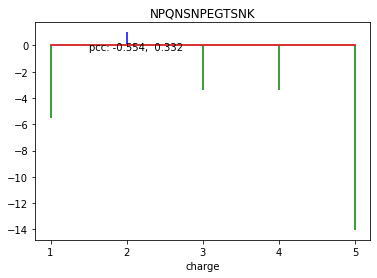

In [87]:
plot_zfit(kb_X, kb_y, kb_pred_log, 9)

In [94]:
pred_logs = []
for real, pred in zip(kb_y, kb_pred_log):
    idxes = np.where(real==1)[0]
    pred_logs += list(pred[idxes])

/home/bis/miniconda3/envs/bis/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


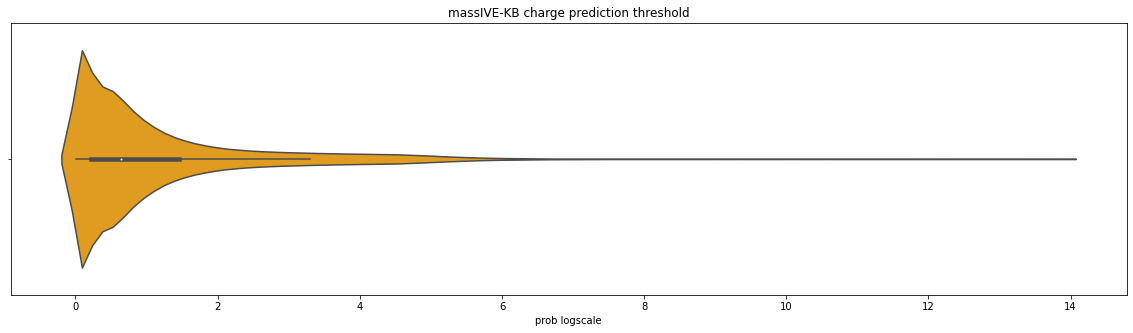

In [101]:
plt.figure(figsize=(20,5))
sns.violinplot(pred_logs, color='orange')
plt.title('massIVE-KB charge prediction threshold')
plt.xlabel('prob logscale')
plt.show()

In [109]:
print('[only real charge] below 6 ratio : ', len(list(filter(lambda x: x<=6, pred_logs)))/len(pred_logs))

[only real charge] below 6 ratio :  0.9929168711540639


In [108]:
all_logs = [__ for _ in kb_pred_log for __ in _]
print('[all charge] below 6 ratio : ', len(list(filter(lambda x: x<=6, all_logs)))/len(all_logs))

[all charge] below 6 ratio :  0.5813019145317448


# 위 threshold에 따라 pep2charge tensor를 구성
# 그 값에 MS2 예측해서 새로운 input 생성!

In [110]:
# Charge prediction

In [ ]:
# additional prediction charge 6 peptide 
all_X_str = np.array(list(set(whole_pep)))

all_onehot = dict()
for p in all_X_str:
    o = one_hot_encode_peptide(p)
    all_onehot[p] = o[1]
all_X = np.array(list(all_onehot.values()))

all_pred = network_ori.predict(all_X)
all_pred_log = np.array([np.array(list(map(lambda x: -math.log(x), _))) for _ in all_pred])

print(all_X_str.shape, all_X.shape, all_pred_log.shape)

In [14]:
peplist = []
for p, prob in zip(all_X_str, all_pred_log):
    idxes = np.where(prob<=6)[0]
    charges = idxes + 1  # casting
    for c in charges:
        peplist.append([p, 30, c])

df_peplist = pd.DataFrame(peplist, columns=['modified_sequence', 'collision_energy', 'precursor_charge'])

In [15]:
df_peplist.to_csv('noPTM_MS2_prediction211008.csv', index=False)

In [5]:
df_peplist = pd.read_csv('noPTM_MS2_prediction211008.csv')
print(df_peplist.shape)
df_peplist.head(2)

(1468674, 3)


,modified_sequence,collision_energy,precursor_charge
0,RISPARETR,30,1
1,RISPARETR,30,2


In [ ]:
# make server MODEL_ECTRA=/home/bis/2021_SJH_detectability/Detectability/refModel/2019Nat_Prosit/prosit-master/preTrained/frag/prosit1/ MODEL_IRT=/home/bis/2021_SJH_detectability/Detectability/refModel/2019Nat_Prosit/prosit-master/preTrained/irt/model_irt_prediction/

In [16]:
!curl -F "peptides=@noPTM_MS2_prediction211008.csv" http://127.0.0.1:5000/predict/msms --output noPTM_MS2_prediction211008_result.msms

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.4M    0     0  100 30.4M      0   778k  0:00:40  0:00:40 --:--:--     0^C


# Make MS2 tensor pickle

In [ ]:
df_ms2 = pd.read_csv('noPTM_MS2_prediction211008_result.msms', sep='\t')

In [6]:
print(df_ms2.shape)
df_ms2.head(2)

(1468674, 5)


,Intensities,Masses,Matches,Modified Sequence,Charge
0,0.11973064;1.0;0.014851017;0.04148714;0.039550...,175.118952167;276.166631167;405.209224167;729....,y1;y2;y3;y6;y7;y8;b1;b2;b3;b7;b8,RISPARETR,1
1,0.31035903;1.0;0.03278381;0.008371239;0.044243...,175.118952167;276.166631167;405.209224167;729....,y1;y2;y3;y6;y7;y8;b1;b2;b3;b5;b6;b7;b8;y6(2+);...,RISPARETR,2


In [7]:
masses = [int(__) for _ in df_ms2.Masses.values for __ in list(map(float, _.split(';')))]
pd.DataFrame(masses).describe()

,0
count,5.583910e+07
mean,6.572690e+02
std,3.759977e+02
min,2.000000e+01
25%,3.740000e+02
50%,6.000000e+02
75%,8.680000e+02
max,3.756000e+03


/home/bis/miniconda3/envs/bis/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


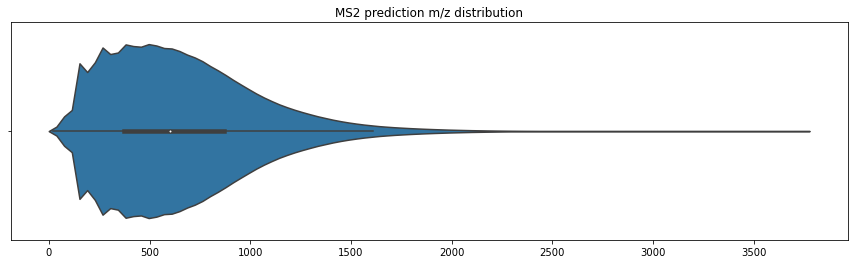

In [8]:
plt.figure(figsize=(15,4))
sns.violinplot(masses)  # 2000DA 까지 사용
plt.title('MS2 prediction m/z distribution')
plt.show()

In [9]:
cols = ['Intensities', 'Masses', 'Modified Sequence', 'Charge']
pep2cmzint = {p:[c, m, i] for i, m, p, c in df_ms2[cols].values}

get_idx = lambda x: int(round(float(x), 2)*100)

def get_spectrum(pep2cmzint):
    pep2tensor = dict()
    for pep, (c, m, i) in pep2cmzint.items():
        tensor = np.zeros((5, 100000))
        i = np.array(list(map(float, i.split(';'))))
        m2idx = np.array(list(map(get_idx, m.split(';'))))
        idx2inten = {k:v for k, v in zip(m2idx, i) if k <= 100000-1}  # Dalton 제한
        
        row_idx = c-1
        col_idx = np.array(list(idx2inten.keys()))
        val = np.array(list(idx2inten.values()))
        tensor[row_idx, col_idx] = val
        
        pep2tensor[pep]=tensor
    return pep2tensor

pep2tensor = get_spectrum(pep2cmzint)

In [12]:
len(pep2tensor)

492693

In [13]:
list(pep2tensor.keys())[0]

'RISPARETR'

In [14]:
list(pep2tensor.values())[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])